In [1]:
import numpy as np
import random
import matplotlib.pyplot as plt

In [2]:
class MazeEnv:
    """
    Grid legend:
      0: free cell
      1: wall
      S: start (given as coord)
      G: goal  (given as coord)
    Actions: 0=up, 1=right, 2=down, 3=left
    Reward: -1 per step, +20 on goal, -5 penalty if bumping wall (stays in place)
    Episode ends at goal or after max_steps.
    """
    def __init__(self, grid, start, goal, max_steps=None):
        self.grid = np.array(grid, dtype=int)
        self.n_rows, self.n_cols = self.grid.shape
        self.start = start
        self.goal = goal
        self.state = start
        self.action_space_n = 4
        self.observation_space_n = self.n_rows * self.n_cols
        self.max_steps = max_steps or (self.n_rows * self.n_cols * 4)
        self.step_count = 0

    def reset(self):
        self.state = self.start
        self.step_count = 0
        return self._to_state_index(self.state)

    def step(self, action):
        r, c = self.state
        drc = {0: (-1, 0), 1: (0, 1), 2: (1, 0), 3: (0, -1)}
        dr, dc = drc[action]
        nr, nc = r + dr, c + dc

        reward = -1  # time penalty to encourage shortest paths
        done = False

        # Out of bounds or wall -> penalty and stay
        if not (0 <= nr < self.n_rows and 0 <= nc < self.n_cols) or self.grid[nr, nc] == 1:
            reward += -5
            nr, nc = r, c  # no move
        else:
            # valid move
            pass

        self.state = (nr, nc)
        self.step_count += 1

        if self.state == self.goal:
            reward += 20
            done = True

        if self.step_count >= self.max_steps:
            done = True

        return self._to_state_index(self.state), reward, done, {}

    def _to_state_index(self, rc):
        r, c = rc
        return r * self.n_cols + c

    def _from_state_index(self, idx):
        return divmod(idx, self.n_cols)

    def render(self, path=None):
        """ASCII rendering; optional path highlights with '*'."""
        display = np.array(self.grid, dtype=object)
        display[:] = ' '
        display[self.grid == 1] = '#'
        sr, sc = self.start
        gr, gc = self.goal
        display[sr, sc] = 'S'
        display[gr, gc] = 'G'
        if path:
            for (r, c) in path:
                if (r, c) not in [(sr, sc), (gr, gc)]:
                    display[r, c] = '*'
        print("\n".join("".join(row) for row in display))

    def valid_cells(self):
        """Return list of free (non-wall) cell indices for convenience."""
        cells = []
        for r in range(self.n_rows):
            for c in range(self.n_cols):
                if self.grid[r, c] != 1:
                    cells.append(self._to_state_index((r, c)))
        return cells

In [3]:

# ------------------------------
# Q-Learning Agent
# ------------------------------
class QLearningAgent:
    def __init__(self, n_states, n_actions, alpha=0.1, gamma=0.98, epsilon=1.0, epsilon_min=0.05, epsilon_decay=0.995):
        self.n_states = n_states
        self.n_actions = n_actions
        self.Q = np.zeros((n_states, n_actions))
        self.alpha = alpha
        self.gamma = gamma
        self.epsilon = epsilon
        self.epsilon_min = epsilon_min
        self.epsilon_decay = epsilon_decay

    def select_action(self, state):
        if random.random() < self.epsilon:
            return random.randrange(self.n_actions)
        return int(np.argmax(self.Q[state]))

    def update(self, s, a, r, s_next, done):
        best_next = 0.0 if done else np.max(self.Q[s_next])
        td_target = r + self.gamma * best_next
        self.Q[s, a] += self.alpha * (td_target - self.Q[s, a])

    def decay_epsilon(self):
        self.epsilon = max(self.epsilon_min, self.epsilon * self.epsilon_decay)


In [5]:
# ------------------------------
# Helper: extract greedy policy & shortest path
# ------------------------------
ARROWS = {0: '↑', 1: '→', 2: '↓', 3: '←'}

def print_policy(env, Q):
    print("\nGreedy policy (arrows) over free cells:")
    for r in range(env.n_rows):
        row_chars = []
        for c in range(env.n_cols):
            if env.grid[r, c] == 1:
                row_chars.append('#')
            else:
                idx = env._to_state_index((r, c))
                if (r, c) == env.start:
                    row_chars.append('S')
                elif (r, c) == env.goal:
                    row_chars.append('G')
                else:
                    row_chars.append(ARROWS[int(np.argmax(Q[idx]))])
        print("".join(row_chars))

In [6]:
def greedy_path(env, Q, max_steps=500):
    """Follow greedy policy from start; stop on loops or when reaching goal."""
    visited = set()
    path = [env.start]
    current = env.start
    for _ in range(max_steps):
        if current == env.goal:
            break
        if current in visited:
            # loop detected
            break
        visited.add(current)
        s = env._to_state_index(current)
        a = int(np.argmax(Q[s]))
        # simulate move
        r, c = current
        drc = {0: (-1, 0), 1: (0, 1), 2: (1, 0), 3: (0, -1)}
        dr, dc = drc[a]
        nr, nc = r + dr, c + dc
        if not (0 <= nr < env.n_rows and 0 <= nc < env.n_cols) or env.grid[nr, nc] == 1:
            # stuck: break
            break
        current = (nr, nc)
        path.append(current)
        if current == env.goal:
            break
    return path

Episode 200/2000 | epsilon=0.367 | total_reward=4
Episode 400/2000 | epsilon=0.135 | total_reward=10
Episode 600/2000 | epsilon=0.050 | total_reward=10
Episode 800/2000 | epsilon=0.050 | total_reward=4
Episode 1000/2000 | epsilon=0.050 | total_reward=10
Episode 1200/2000 | epsilon=0.050 | total_reward=10
Episode 1400/2000 | epsilon=0.050 | total_reward=10
Episode 1600/2000 | epsilon=0.050 | total_reward=8
Episode 1800/2000 | epsilon=0.050 | total_reward=4
Episode 2000/2000 | epsilon=0.050 | total_reward=4

Greedy policy (arrows) over free cells:
S←→↓→↓
↓##↓#↓
→↓#↓#↓
#↓#→→↓
→→↓##↓
↑#→→→G

Learned greedy path length: 11
S     
*## # 
**# # 
#*#   
 **## 
 #***G


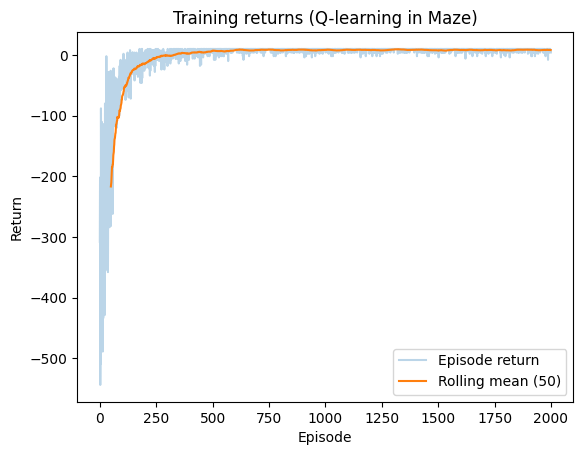

In [7]:
# ------------------------------
# Example Maze and Training
# ------------------------------
if __name__ == "__main__":
    # 0 = free, 1 = wall
    # You can edit this layout easily.
    grid = [
        [0, 0, 0, 0, 0, 0],
        [0, 1, 1, 0, 1, 0],
        [0, 0, 1, 0, 1, 0],
        [1, 0, 1, 0, 0, 0],
        [0, 0, 0, 1, 1, 0],
        [0, 1, 0, 0, 0, 0],
    ]
    start = (0, 0)
    goal  = (5, 5)

    env = MazeEnv(grid, start, goal)

    agent = QLearningAgent(
        n_states=env.observation_space_n,
        n_actions=env.action_space_n,
        alpha=0.2,
        gamma=0.98,
        epsilon=1.0,
        epsilon_min=0.05,
        epsilon_decay=0.995
    )

    episodes = 2000
    rewards_history = []

    for ep in range(episodes):
        s = env.reset()
        done = False
        total_reward = 0

        while not done:
            a = agent.select_action(s)
            s_next, r, done, _ = env.step(a)
            agent.update(s, a, r, s_next, done)
            s = s_next
            total_reward += r

        agent.decay_epsilon()
        rewards_history.append(total_reward)

        if (ep + 1) % 200 == 0:
            print(f"Episode {ep+1}/{episodes} | epsilon={agent.epsilon:.3f} | total_reward={total_reward}")

    # Show learned policy
    print_policy(env, agent.Q)

    # Show greedy path from start after learning
    path = greedy_path(env, agent.Q)
    print("\nLearned greedy path length:", len(path))
    env.render(path=path)

    # Plot rewards trend
    plt.figure()
    window = 50
    rolling = np.convolve(rewards_history, np.ones(window)/window, mode='valid')
    plt.plot(rewards_history, alpha=0.3, label="Episode return")
    plt.plot(range(window-1, window-1+len(rolling)), rolling, label=f"Rolling mean ({window})")
    plt.xlabel("Episode")
    plt.ylabel("Return")
    plt.title("Training returns (Q-learning in Maze)")
    plt.legend()
    plt.show()

Maze layout:
 S  .  .  .  .  .  .  .  . 
 . ###### . ############ . 
 . ### .  .  .  .  . ### . 
 . ### . ######### . ### . 
 .  .  . ### .  .  . ### . 
 . ### . ### . ### .  .  . 
 .  .  .  .  . ### . ### G 

Episode 1/2500 - Reward: -18.24 - Success%: 100.0% - Epsilon: 0.298
Episode 200/2500 - Reward: 0.28 - Success%: 100.0% - Epsilon: 0.110
Episode 400/2500 - Reward: -0.12 - Success%: 100.0% - Epsilon: 0.040
Episode 600/2500 - Reward: 0.48 - Success%: 100.0% - Epsilon: 0.015
Episode 800/2500 - Reward: 0.48 - Success%: 100.0% - Epsilon: 0.010
Episode 1000/2500 - Reward: 0.48 - Success%: 100.0% - Epsilon: 0.010
Episode 1200/2500 - Reward: 0.48 - Success%: 100.0% - Epsilon: 0.010
Episode 1400/2500 - Reward: 0.48 - Success%: 100.0% - Epsilon: 0.010
Episode 1600/2500 - Reward: 0.48 - Success%: 100.0% - Epsilon: 0.010
Episode 1800/2500 - Reward: 0.48 - Success%: 100.0% - Epsilon: 0.010
Episode 2000/2500 - Reward: 0.48 - Success%: 100.0% - Epsilon: 0.010
Episode 2200/2500 - Reward: 0.48 - 

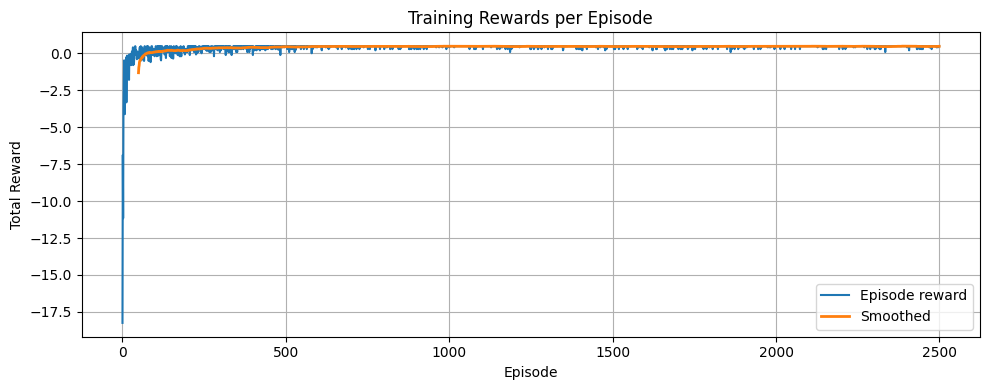

Final greedy policy:
 S  →  →  →  →  →  →  →  ↓ 
 ↑ ###### ↓ ############ ↓ 
 ← ### →  →  →  →  ↓ ### ↓ 
 ↓ ### ↑ ######### ↓ ### ↓ 
 →  →  ↓ ### →  →  ↓ ### ↓ 
 ↓ ### ↓ ### ↑ ### →  →  ↓ 
 →  →  →  →  ↑ ### ↑ ### G 

Path taken by greedy policy:
[(0, 0), (0, 1), (0, 2), (0, 3), (0, 4), (0, 5), (0, 6), (0, 7), (0, 8), (1, 8), (2, 8), (3, 8), (4, 8), (5, 8), (6, 8)]
Reached goal? True


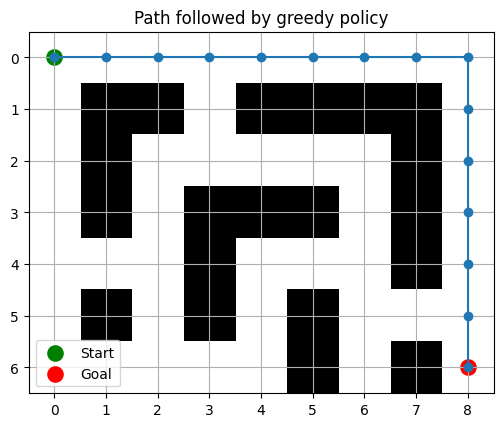

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import random
from collections import defaultdict, deque

class MazeEnv:
    def __init__(self, grid, start, goal, step_reward=-0.04, goal_reward=1.0, hit_wall_reward=-0.2):
        self.grid = np.array(grid)
        self.start = start
        self.goal = goal
        self.step_reward = step_reward
        self.goal_reward = goal_reward
        self.hit_wall_reward = hit_wall_reward
        self.n_rows, self.n_cols = self.grid.shape
        self.action_space = [0,1,2,3]
        self.reset()

    def reset(self):
        self.agent_pos = tuple(self.start)
        return self.agent_pos

    def in_bounds(self, r, c):
        return 0 <= r < self.n_rows and 0 <= c < self.n_cols

    def is_free(self, r, c):
        return self.in_bounds(r,c) and self.grid[r,c] == 0

    def step(self, action):
        r, c = self.agent_pos
        if action == 0:
            nr, nc = r-1, c
        elif action == 1:
            nr, nc = r, c+1
        elif action == 2:
            nr, nc = r+1, c
        elif action == 3:
            nr, nc = r, c-1
        if not self.is_free(nr, nc):
            reward = self.hit_wall_reward
            done = False
            next_state = (r,c)
        else:
            next_state = (nr,nc)
            if next_state == tuple(self.goal):
                reward = self.goal_reward
                done = True
            else:
                reward = self.step_reward
                done = False
        self.agent_pos = next_state
        return next_state, reward, done

    def render_text(self, policy=None, q_table=None):
        arrow_map = {0:'↑',1:'→',2:'↓',3:'←'}
        out = ""
        for i in range(self.n_rows):
            for j in range(self.n_cols):
                if (i,j) == tuple(self.goal):
                    out += " G "
                elif (i,j) == tuple(self.start):
                    out += " S "
                elif self.grid[i,j] == 1:
                    out += "###"
                else:
                    if policy and (i,j) in policy:
                        out += f" {arrow_map[policy[(i,j)]]} "
                    elif q_table and (i,j) in q_table:
                        greedy = np.argmax(q_table[(i,j)])
                        out += f" {arrow_map[greedy]} "
                    else:
                        out += " . "
            out += "\n"
        print(out)

    def all_states(self):
        for i in range(self.n_rows):
            for j in range(self.n_cols):
                if self.grid[i,j] == 0 or (i,j) == tuple(self.goal) or (i,j) == tuple(self.start):
                    yield (i,j)

class QLearningAgent:
    def __init__(self, actions, alpha=0.5, gamma=0.99, epsilon=0.1):
        self.actions = actions
        self.alpha = alpha
        self.gamma = gamma
        self.epsilon = epsilon
        self.q = defaultdict(lambda: np.zeros(len(actions)))

    def choose_action(self, state):
        if random.random() < self.epsilon:
            return random.choice(self.actions)
        else:
            return int(np.argmax(self.q[state]))

    def update(self, state, action, reward, next_state, done):
        qsa = self.q[state][action]
        if done:
            target = reward
        else:
            target = reward + self.gamma * np.max(self.q[next_state])
        self.q[state][action] = qsa + self.alpha * (target - qsa)

    def get_policy(self):
        policy = {}
        for s, qvals in self.q.items():
            policy[s] = int(np.argmax(qvals))
        return policy

def build_sample_maze():
    grid = [
        [0,0,0,0,0,0,0,0,0],
        [0,1,1,0,1,1,1,1,0],
        [0,1,0,0,0,0,0,1,0],
        [0,1,0,1,1,1,0,1,0],
        [0,0,0,1,0,0,0,1,0],
        [0,1,0,1,0,1,0,0,0],
        [0,0,0,0,0,1,0,1,0],
    ]
    start = (0,0)
    goal = (6,8)
    return np.array(grid), start, goal

def train_q_learning(env, episodes=2000, max_steps=200, alpha=0.5, gamma=0.99, epsilon=0.2, decay_epsilon=False):
    agent = QLearningAgent(actions=env.action_space, alpha=alpha, gamma=gamma, epsilon=epsilon)
    rewards_history = []
    success_history = deque(maxlen=100)
    for ep in range(1, episodes+1):
        state = env.reset()
        total_reward = 0.0
        done = False
        for step in range(max_steps):
            action = agent.choose_action(state)
            next_state, reward, done = env.step(action)
            agent.update(state, action, reward, next_state, done)
            state = next_state
            total_reward += reward
            if done:
                break
        rewards_history.append(total_reward)
        success_history.append(1 if done else 0)
        if decay_epsilon:
            agent.epsilon = max(0.01, agent.epsilon * 0.995)
        if ep % 200 == 0 or ep == 1:
            recent_success_rate = np.mean(list(success_history)) if len(success_history) > 0 else 0.0
            print(f"Episode {ep}/{episodes} - Reward: {total_reward:.2f} - Success%: {recent_success_rate*100:.1f}% - Epsilon: {agent.epsilon:.3f}")
    return agent, rewards_history

def plot_rewards(rewards):
    plt.figure(figsize=(10,4))
    plt.plot(rewards, label='Episode reward')
    window = max(1, len(rewards)//50)
    smoothed = np.convolve(rewards, np.ones(window)/window, mode='valid')
    plt.plot(range(window-1, window-1+len(smoothed)), smoothed, label='Smoothed', linewidth=2)
    plt.xlabel('Episode')
    plt.ylabel('Total Reward')
    plt.title('Training Rewards per Episode')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

def visualize_policy(env, q_table):
    policy = {}
    for s in env.all_states():
        if s in q_table:
            policy[s] = int(np.argmax(q_table[s]))
    print("Final greedy policy:")
    env.render_text(policy=policy)

def run_episode_with_policy(env, agent, max_steps=200, render=True):
    state = env.reset()
    path = [state]
    for _ in range(max_steps):
        action = int(np.argmax(agent.q[state]))
        next_state, reward, done = env.step(action)
        path.append(next_state)
        state = next_state
        if done:
            break
    if render:
        print("Path taken by greedy policy:")
        print(path)
    return path, done

def main():
    grid, start, goal = build_sample_maze()
    env = MazeEnv(grid, start, goal, step_reward=-0.04, goal_reward=1.0, hit_wall_reward=-0.2)
    print("Maze layout:")
    env.render_text()
    agent, rewards = train_q_learning(env, episodes=2500, max_steps=200,
                                      alpha=0.6, gamma=0.98, epsilon=0.3, decay_epsilon=True)
    plot_rewards(rewards)
    visualize_policy(env, agent.q)
    path, success = run_episode_with_policy(env, agent, render=True)
    print("Reached goal?", success)
    coords = np.array(path)
    fig, ax = plt.subplots(figsize=(6,6))
    ax.imshow(env.grid==1, cmap='gray_r')
    ax.plot(coords[:,1], coords[:,0], marker='o')
    ax.scatter(start[1], start[0], c='green', s=120, label='Start')
    ax.scatter(goal[1], goal[0], c='red', s=120, label='Goal')
    ax.set_title('Path followed by greedy policy')
    ax.set_xlim(-0.5, env.n_cols-0.5)
    ax.set_ylim(env.n_rows-0.5, -0.5)
    ax.legend()
    plt.grid(True)
    plt.show()

if __name__ == "__main__":
    main()